In [1]:
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 读入数据
TrainData = pd.read_csv('data/Train_Data.csv')
TestData = pd.read_csv('data/Test_Data.csv')
TrainData = TrainData[['id','text','entity','negative','key_entity']]
TestData = TestData[['id','text','entity']]

In [3]:
import jieba
# 去除特殊符号
import re
# 分句子和分实体
pattern_sen = r';|\?|!|。|；|！|…'
pattern_semi = r';|；'
def CutContent(content,pattern):
    content = re.split(pattern, str(content))
    return content
# 清洗数据函数
def RemovePunctuation(content):
    punctuation = '#,??,???,;;,!!,。。, '
    content = re.sub(r'[{}]+'.format(punctuation),'',str(content))
    return content.strip('?').lower()


In [4]:
#补充缺失值
TrainData=TrainData.fillna('无')
TestData=TestData.fillna('无')
#将句子的无关符号清洗
TrainData['text'] = TrainData['text'].apply(lambda x:RemovePunctuation(x))
TestData['text'] = TestData['text'].apply(lambda x:RemovePunctuation(x))

In [5]:
#训练集的实体变成列表
TrainData['entity'] = TrainData['entity'].map(lambda x :CutContent(x,pattern_semi))

In [6]:
#测试机的实体变成列表
TestData['entity'] = TestData['entity'].map(lambda x :CutContent(x,pattern_semi))

In [7]:
TrainData['entity'][1][0]

'小资钱包'

In [8]:
# 将训练集数据按照实体排序
TrainMiddle = TrainData[['id','text','entity','negative','key_entity']]
k=0
for i in range(len(TrainData)):
    for j in range(len(TrainData['entity'][i])):
        TrainMiddle.loc[k,'id']=TrainData['id'][i]
        TrainMiddle.loc[k,'text']=TrainData['text'][i]
        TrainMiddle.loc[k,'entity']=TrainData['entity'][i][j]
        TrainMiddle.loc[k,'negative']=TrainData['negative'][i]
        TrainMiddle.loc[k,'key_entity']=TrainData['key_entity'][i]
        k=k+1

In [9]:
# 将测试集数据按照实体排序
TestMiddle = TestData[['id','text','entity']]
k=0
for i in range(len(TestData)):
    for j in range(len(TestData['entity'][i])):
        TestMiddle.loc[k,'id']=TestData['id'][i]
        TestMiddle.loc[k,'text']=TestData['text'][i]
        TestMiddle.loc[k,'entity']=TestData['entity'][i][j]
        k=k+1

In [10]:
# entity<==>key_entity  判断该实体是不是消极实体
def IsNegative(keyname,name):
    if keyname.find(name) != -1:
        return '1'
    else :
        return '0'


In [11]:
# entity<==>text 寻找自己所属的句子
def isContent(content,entity):
    if content.find(entity) != -1:
        return str(content)
    else :
        return '无'

In [12]:
# 判断训练集entity<==>key_entity
for i in range(len(TrainMiddle)):
    TrainMiddle.loc[i,'negative_self'] = IsNegative(TrainMiddle['key_entity'][i],TrainMiddle['entity'][i])

In [13]:
#训练集和测试集文章按照句子切割
TrainMiddle['text'] =  TrainMiddle['text'].map(lambda x :CutContent(x,pattern_sen))
TestMiddle['text'] =  TestMiddle['text'].map(lambda x :CutContent(x,pattern_sen))

In [14]:
# 将训练集entity <==> text,每个实体找所属的句子
for i in range(len(TrainMiddle)):
    x=''
    for j in range(len(TrainMiddle['text'][i])):
        x=x+isContent(TrainMiddle['text'][i][j],TrainMiddle['entity'][i])
    TrainMiddle.loc[i,'text_self']=x

In [15]:
# 将测试集entity <==> text,每个实体找所属的句子
for i in range(len(TestMiddle)):
    x=''
    for j in range(len(TestMiddle['text'][i])):
        x=x+isContent(TestMiddle['text'][i][j],TestMiddle['entity'][i])
    TestMiddle.loc[i,'text_self']=x

In [16]:
# 去除特殊符号
import re
def ClearSeq(article):
    article = re.sub(r"[0-9\s+\.\!\/_,$%^*()?;；:-【】+\"\']+|[+——！，;:。？、~@#￥%……&*（）]+", " ",article) #去标点符号
    article = article.replace(' ','')  #去前后的空格
    return article

In [17]:
#训练集清除所有符号，结巴分词
TrainMiddle['text_self'] = TrainMiddle['text_self'].apply(lambda x:ClearSeq(x))
TrainMiddle['words'] = TrainMiddle['text_self'].apply(lambda x:list(jieba.cut(x)))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\cheng\AppData\Local\Temp\jieba.cache
Loading model cost 0.590 seconds.
Prefix dict has been built succesfully.


In [18]:
#测试集清除所有符号，结巴分词
TestMiddle['text_self'] = TestMiddle['text_self'].apply(lambda x:ClearSeq(x))
TestMiddle['words'] = TestMiddle['text_self'].apply(lambda x:list(jieba.cut(x)))

In [19]:
all_words = []
    #追加多个词
for w in TrainMiddle['words']:
    all_words.extend(w)
for w in TestMiddle['words']:
    all_words.extend(w)

In [20]:
 # 构造词典
word_dict = pd.DataFrame(pd.Series(all_words).value_counts())
word_dict['id'] = list(range(1,len(word_dict)+1))


In [ ]:
TrainMiddle['words'].mean()
# TestMiddle['words']

In [21]:
from keras.preprocessing import sequence
# 将训练集文本映射为数字
TrainMiddle['w2v'] = TrainMiddle['words'].apply(lambda x:list(word_dict['id'][x]))
    #压缩为50维v
TrainMiddle['w2v'] = list(sequence.pad_sequences(TrainMiddle['w2v'],maxlen=50))

Using TensorFlow backend.


In [26]:
# 将测试集文本映射为数字
TestMiddle['w2v'] = TestMiddle['words'].apply(lambda x:list(word_dict['id'][x]))
    #压缩为50维v
TestMiddle['w2v'] = list(sequence.pad_sequences(TestMiddle['w2v'],maxlen=50))

In [27]:
# 训练和测试数据
import numpy as np
x_train = np.array(list(TrainMiddle['w2v']))[::2]
y_train = np.array(list(TrainMiddle['negative_self']))[::2]
x_test = np.array(list(TrainMiddle['w2v']))[1::2]
y_test = np.array(list(TrainMiddle['negative_self']))[1::2]

In [52]:
x_test = np.array(list(TestMiddle['w2v']))

In [64]:
x_train = np.array(list(TrainMiddle['w2v']))
y_train = np.array(list(TrainMiddle['negative_self']))

In [77]:
# LSTM模型构建
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import LSTM, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

model = Sequential()
model.add(Embedding(len(word_dict)+1,512))
# model.add(GRU(256))
model.add(Bidirectional(GRU(256, return_sequences = False)))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer = Adam(1e-3),metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 512)         18111488  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 513       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 19,294,721
Trainable params: 19,294,721
Non-trainable params: 0
_________________________________________________________________


In [65]:
y_train=y_train.astype(np.int32)
y_test=y_test.astype(np.int32)

In [31]:
type(np.array(list(TrainMiddle['w2v'])))

numpy.ndarray

In [60]:
#使用gpu
import keras.backend.tensorflow_backend as KTF
from tensorflow.compat.v1 import ConfigProto
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.compat.v1.Session(config=config)
KTF.set_session(sess)

In [32]:
y_train

array([0, 1, 0, ..., 1, 1, 1])

In [44]:
TrainMiddle['negative_self']

0        0
1        0
2        1
3        1
4        0
        ..
11461    0
11462    1
11463    1
11464    1
11465    0
Name: negative_self, Length: 11466, dtype: int32

In [78]:
# 模型训练
model.fit(x_train,y_train,batch_size=32,epochs=7)

Train on 11466 samples
Epoch 1/7
11466/11466 [==============================] - 99s 9ms/sample - loss: 0.3677 - accuracy: 0.8461
Epoch 2/7
11466/11466 [==============================] - 97s 8ms/sample - loss: 0.2529 - accuracy: 0.8903
Epoch 3/7
11466/11466 [==============================] - 99s 9ms/sample - loss: 0.2176 - accuracy: 0.8943
Epoch 4/7
11466/11466 [==============================] - 97s 8ms/sample - loss: 0.1965 - accuracy: 0.8965
Epoch 5/7
11466/11466 [==============================] - 96s 8ms/sample - loss: 0.1845 - accuracy: 0.9028
Epoch 6/7
11466/11466 [==============================] - 97s 8ms/sample - loss: 0.1787 - accuracy: 0.9017
Epoch 7/7
11466/11466 [==============================] - 96s 8ms/sample - loss: 0.1791 - accuracy: 0.9043


In [79]:
model.evaluate(x=x_test,y=y_test,verbose=0)

[0.1636063926988885, 0.9134833]

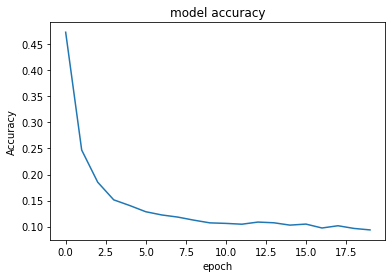

In [50]:
import matplotlib.pyplot as plt
history = model.history
plt.plot(history.history['loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.show()

In [54]:
def predict_data(new_comment):
    words = list(jieba.cut(new_comment))
    w2v = [word_dict['id'][x] for x in words]
    xn = sequence.pad_sequences([w2v],maxlen=50)
    return xn

# xn = predict_data(a)
# model.predict_classes(a,verbose=0)

In [57]:
x=model.predict_classes(x_test,verbose=0)

In [62]:
TestMiddle['negative']=x

In [63]:
submit = pd.read_csv('data/Submit_Example.csv')

In [64]:
k=0
for i in range(len(submit['id'])):
    if(k>=11580):
        break
    x=''
    while(str(TestMiddle['id'][k])==str(submit['id'][i])):
        
        if(str(TestMiddle['negative'][k])=='1'):
            submit.loc[i,'negative']=1;
            x=x+str(TestMiddle['entity'][k])+';'
        k=k+1
        if(k>=11580):
            break
    submit.loc[i,'key_entity']=x

In [68]:
submit=submit.fillna('')

In [69]:
submit.to_csv('submit_lstm.csv',encoding="utf_8_sig",index=None)

In [70]:
submit

,id,negative,key_entity
0,f3b61b38,1,小资钱包;资易贷;
1,84b12bae,0,
2,6abf4a82,0,
3,8d076785,1,易捷金融;宜贷网;
4,d65a1577,1,贵金属;
...,...,...,...
4995,cf4782db,0,
4996,36895a84,0,
4997,46e3ae0b,0,
4998,31e49e9d,0,
